In [1]:
import pandas as pd
import tweepy
import requests
import os
from io import StringIO
import json
import numpy as np

## Gather

In [2]:
#bring in WeRateDogs Twitter archive
wrd = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
#get Tweet image predictions using Requests
#help from: https://stackoverflow.com/questions/32400867/pandas-read-csv-from-url?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
s = requests.get(url).text
image_predictions = pd.read_csv(StringIO(s),sep = '\t')
image_predictions.head()
image_predictions.to_csv('image_predictions.tsv', index=False)

In [4]:
#!!!!Twitter info - delete info in this cell before submitting!!!

consumer_key = xxx
consumer_secret = xxx
access_token = xxx
access_secret = xxx


In [5]:
#Bring in tweet info from Twitter's API

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

In [8]:
#create a list of tweet ID's to query
#help from: https://stackoverflow.com/questions/18982610/difference-between-except-and-except-exception-as-e-in-python

tweet_ids = wrd['tweet_id']

error_list = []

with open('tweet_json.txt', 'a') as f:
    for i in tweet_ids:
        try:
            tweet = api.get_status(i,tweet_mode = 'extended', wait_on_rate_limit = True,
                                       wait_on_rate_limit_notify = True)
            json.dump(tweet._json, f)
            f.write('\n')
        except Exception as e:
            error_list.append(i)

In [4]:
#open JSON file and read it into a pandas dataframe
#need to capture the 'favorite_count' and 'retweet_count' columns, along with the 'id' (located in 'extended_entities)

add_tweet_data = pd.read_json(open('tweet_json.txt'), lines=True)

## Asses

### Quality issues
1. Retweets are included in the Twitter_Archive_Enhanced dataset. 
2. 'timestamp' in Twitter_archive_enhanced should be datetime.  
3. Some ratings are less than 10, which does not align with the pattern of numerators > 10. (They're good dogs, afterall.)  
4. The max rating_numerator is 1776, when they should all be less than 15. (Only really, REALLY good dogs get a 15.) 
5. There are some non-"10" rating_denominator values.  
6. In the JSON data, the Tweet ID and ID_str are duplicates.
7. There are some entries in the Additional Tweet Data that are retweets.  
8. In the Additional Tweet Data, id_str has duplicates.  

### Tidyness issues

9. In Twitter_archive_enhanced, columns "doggo/floofer/pupper/puppo" do not follow the rule "each variable forms a column".  
10. Image_predictions and Add_Tweet_data can be merged into Twitter_archive_enhanced to create one dataframe instead of three.  

### First, I'll look at wrd (weratedogs) dataframe to see what kind of issues I can detect.

In [7]:
wrd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [5]:
#check the first few rows
wrd.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [6]:
#check 10 random rows
wrd.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2116,670427002554466305,NaN,NaN,2015-11-28 02:20:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Deciduous Trimester mix named Spork....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670427002...,9,10,a,None,None,None,None
2254,667782464991965184,NaN,NaN,2015-11-20 19:12:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Super rare dog. Endangered (?). Thinks it's fu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667782464...,9,10,None,None,None,None,None
1683,681694085539872773,NaN,NaN,2015-12-29 04:31:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He's a Benedoop Cumbersnatch. Seem...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/681694085...,11,10,Bo,None,None,pupper,None
476,816014286006976512,NaN,NaN,2017-01-02 20:12:21 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Larry. He has no self c...,7.320056e+17,4.196984e+09,2016-05-16 00:31:53 +0000,https://twitter.com/dog_rates/status/732005617...,11,10,Larry,None,None,None,None
1278,708853462201716736,NaN,NaN,2016-03-13 03:13:29 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Lucy. She doesn't understand fetch. 8/...,NaN,NaN,NaN,https://vine.co/v/iHl2UDEBZ95,8,10,Lucy,None,None,None,None
1152,725786712245440512,NaN,NaN,2016-04-28 20:40:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Lillie. She's a Rutabagan Floofem...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/725786712...,11,10,Lillie,None,None,pupper,None
2342,666082916733198337,NaN,NaN,2015-11-16 02:38:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a well-established sunblockerspan...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666082916...,6,10,None,None,None,None,None
1231,713177543487135744,NaN,NaN,2016-03-25 01:35:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lance. Lance doesn't give a shit. 10/1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713177543...,10,10,Lance,None,None,None,None
1898,674690135443775488,NaN,NaN,2015-12-09 20:40:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Patrick. He's an exotic pup. Jumps great ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674690135...,3,10,Patrick,None,None,None,None
1462,694905863685980160,NaN,NaN,2016-02-03 15:30:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He's a Bisquick Taj Mapaw. Too...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/694905863...,10,10,Archie,None,None,None,None


In [7]:
#to look at the distribution of the numerical variables
wrd.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [8]:
#to look at the distribution of the rating numerators
wrd['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [9]:
#and look at the distribution of the denominators
wrd['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [10]:
wrd[wrd.tweet_id.duplicated()] #to check to make sure we can use this column as a unique key

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### Now I'll look at image_predictions dataframe.

In [8]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [11]:
#look at the first few rows
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [12]:
#look at a random 10 rows
image_predictions.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1742,822647212903690241,https://pbs.twimg.com/media/C2oRbOuWEAAbVSl.jpg,1,Samoyed,0.416769,True,malamute,0.252706,True,kuvasz,0.157028,True
1958,865359393868664832,https://pbs.twimg.com/media/DAJfxqGVoAAnvQt.jpg,2,Chesapeake_Bay_retriever,0.832435,True,Labrador_retriever,0.163551,True,Weimaraner,0.002770,True
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/88751...,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False
224,670319130621435904,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1148,731156023742988288,https://pbs.twimg.com/media/CiWWhVNUYAAab_r.jpg,1,lakeside,0.501767,False,breakwater,0.051351,False,king_penguin,0.049444,False
1629,805207613751304193,https://pbs.twimg.com/media/CyysDQlVIAAYgrl.jpg,1,Pembroke,0.244705,True,Rhodesian_ridgeback,0.180461,True,Cardigan,0.094664,True
243,670452855871037440,https://pbs.twimg.com/media/CU3tUC4WEAAoZby.jpg,1,Arctic_fox,0.188174,False,indri,0.123584,False,malamute,0.080379,True
2054,888078434458587136,https://pbs.twimg.com/media/DFMWn56WsAAkA7B.jpg,1,French_bulldog,0.995026,True,pug,0.000932,True,bull_mastiff,0.000903,True
1911,853639147608842240,https://pbs.twimg.com/media/C9i8RhhXoAAdkMT.jpg,1,German_shepherd,0.509879,True,malinois,0.237311,True,kelpie,0.046916,True
302,671504605491109889,https://pbs.twimg.com/media/CVGp4LKWoAAoD03.jpg,1,toy_poodle,0.259115,True,bath_towel,0.177669,False,Maltese_dog,0.071712,True


In [13]:
#to see the distribution of the numerical variables
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [14]:
#to see some of the predictions of dog breed
image_predictions['p1'].value_counts().sort_index()

Afghan_hound                       4
African_crocodile                  1
African_grey                       1
African_hunting_dog                1
Airedale                          12
American_Staffordshire_terrier    13
American_black_bear                1
Angora                             2
Appenzeller                        2
Arabian_camel                      3
Arctic_fox                         4
Australian_terrier                 2
Bedlington_terrier                 5
Bernese_mountain_dog              10
Blenheim_spaniel                  11
Border_collie                     12
Border_terrier                     7
Boston_bull                        9
Brabancon_griffon                  3
Brittany_spaniel                   7
Cardigan                          19
Chesapeake_Bay_retriever          23
Chihuahua                         83
Christmas_stocking                 3
Dandie_Dinmont                     6
Doberman                           8
Egyptian_cat                       1
E

In [15]:
#to check to make sure we can use this column as a unique key
image_predictions[image_predictions.tweet_id.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


### Lastly, I'll look at add_tweet_data.

In [16]:
add_tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2474 entries, 0 to 2473
Data columns (total 32 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2474 non-null datetime64[ns]
display_text_range               2474 non-null object
entities                         2474 non-null object
extended_entities                2198 non-null object
favorite_count                   2474 non-null int64
favorited                        2474 non-null bool
full_text                        2474 non-null object
geo                              0 non-null float64
id                               2474 non-null int64
id_str                           2474 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

In [17]:
#look at the first few rows
add_tweet_data.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",38736,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,NaN,NaN,NaN,NaN,8569,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33193,False,This is Tilly. She's just checking pup on you....,NaN,...,NaN,NaN,NaN,NaN,6299,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",24994,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,NaN,NaN,NaN,NaN,4184,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42137,False,This is Darla. She commenced a snooze mid meal...,NaN,...,NaN,NaN,NaN,NaN,8697,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",40273,False,This is Franklin. He would like you to stop ca...,NaN,...,NaN,NaN,NaN,NaN,9458,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [18]:
#look at the distribution of the numerical variables
add_tweet_data.describe()

,contributors,coordinates,favorite_count,geo,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,possibly_sensitive,possibly_sensitive_appealable,quoted_status_id,quoted_status_id_str,retweet_count
count,0.0,0.0,2474.000000,0.0,2.474000e+03,2.474000e+03,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,2336.0,2336.0,2.500000e+01,2.500000e+01,2474.000000
mean,NaN,NaN,9243.701293,NaN,7.500183e+17,7.500183e+17,7.455079e+17,7.455079e+17,2.014171e+16,2.014171e+16,0.0,0.0,8.169687e+17,8.169687e+17,3193.415521
std,NaN,NaN,13142.076182,NaN,7.423869e+16,7.423869e+16,7.582492e+16,7.582492e+16,1.252797e+17,1.252797e+17,0.0,0.0,5.734278e+16,5.734278e+16,5020.245658
min,NaN,NaN,0.000000,NaN,6.660209e+17,6.660209e+17,6.658147e+17,6.658147e+17,1.185634e+07,1.185634e+07,0.0,0.0,7.061659e+17,7.061659e+17,0.000000
25%,NaN,NaN,1498.250000,NaN,6.795782e+17,6.795782e+17,6.757419e+17,6.757419e+17,3.086374e+08,3.086374e+08,0.0,0.0,7.888183e+17,7.888183e+17,632.500000
50%,NaN,NaN,3834.500000,NaN,7.316454e+17,7.316454e+17,7.038708e+17,7.038708e+17,4.196984e+09,4.196984e+09,0.0,0.0,8.322683e+17,8.322683e+17,1548.500000
75%,NaN,NaN,11841.750000,NaN,8.131296e+17,8.131296e+17,8.257804e+17,8.257804e+17,4.196984e+09,4.196984e+09,0.0,0.0,8.664587e+17,8.664587e+17,3837.750000
max,NaN,NaN,143103.000000,NaN,8.924206e+17,8.924206e+17,8.862664e+17,8.862664e+17,8.405479e+17,8.405479e+17,0.0,0.0,8.860534e+17,8.860534e+17,77182.000000


In [19]:
#looking at retweets
add_tweet_data.retweeted.value_counts()

False    2474
Name: retweeted, dtype: int64

In [21]:
#curious about ID vs ID_STR
add_tweet_data['id']

0       892420643555336193
1       892177421306343426
2       891815181378084864
3       891689557279858688
4       891327558926688256
5       891087950875897856
6       890971913173991426
7       890729181411237888
8       890609185150312448
9       890240255349198849
10      890006608113172480
11      889880896479866881
12      889665388333682689
13      889638837579907072
14      889531135344209921
15      889278841981685760
16      888917238123831296
17      888804989199671297
18      888554962724278272
19      892420643555336193
20      892177421306343426
21      891815181378084864
22      891689557279858688
23      891327558926688256
24      891087950875897856
25      890971913173991426
26      890729181411237888
27      890609185150312448
28      890240255349198849
29      890006608113172480
               ...        
2444    666411507551481857
2445    666407126856765440
2446    666396247373291520
2447    666373753744588802
2448    666362758909284353
2449    666353288456101888
2

In [22]:
#curious about ID vs ID_STR
add_tweet_data['id_str']

0       892420643555336192
1       892177421306343424
2       891815181378084864
3       891689557279858688
4       891327558926688256
5       891087950875897856
6       890971913173991424
7       890729181411237888
8       890609185150312448
9       890240255349198848
10      890006608113172480
11      889880896479866880
12      889665388333682688
13      889638837579907072
14      889531135344209920
15      889278841981685760
16      888917238123831296
17      888804989199671296
18      888554962724278272
19      892420643555336192
20      892177421306343424
21      891815181378084864
22      891689557279858688
23      891327558926688256
24      891087950875897856
25      890971913173991424
26      890729181411237888
27      890609185150312448
28      890240255349198848
29      890006608113172480
               ...        
2444    666411507551481856
2445    666407126856765440
2446    666396247373291520
2447    666373753744588800
2448    666362758909284352
2449    666353288456101888
2

## Clean

In [10]:
#first, make a copy of each dataframe
wrd_clean = wrd.copy()
image_predictions_clean = image_predictions.copy()
add_tweet_data_clean = add_tweet_data.copy()

### Issue #1: Retweets are included in the Twitter_Archive_Enhanced dataset. 

I'll need to remove the lines that are retweets. Rows that have a non-null value in the 'retweeted_status_id' column are retweets. Once that is done, I can drop these three columns, since they will be empty: 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'

In [11]:
#code
wrd_clean = wrd_clean[wrd_clean['retweeted_status_id'].apply(np.isnan)]
wrd_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis = 1, inplace = True)

In [12]:
#test, 181 rows are retweets, so expecting the new df to have only 2175 rows (2356 - 181 = 2175)
wrd_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
dtypes: float64(2), int64(3), object(9)
memory usage: 254.9+ KB


### Issue #2: 'timestamp' in Twitter_archive_enhanced should be datetime.

This can be acheived with the 'to.datetime' command.

In [13]:
#code
wrd_clean['timestamp'] = pd.to_datetime(wrd_clean['timestamp'])

In [14]:
#test
wrd_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null datetime64[ns]
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
dtypes: datetime64[ns](1), float64(2), int64(3), object(8)
memory usage: 254.9+ KB


### Issue #3: Some ratings are less than 10, which does not align with the pattern of numerators >= 10.
(They're good dogs, afterall.)



In [15]:
#code (investigate)
wrd_clean_low_num = wrd_clean.query('rating_numerator < 10')
wrd_clean_low_num['expanded_urls'].sample(5)

1869    https://twitter.com/dog_rates/status/675153376...
1103    https://twitter.com/dog_rates/status/735256018...
2128    https://twitter.com/dog_rates/status/670303360...
1406    https://twitter.com/dog_rates/status/699088579...
1070    https://twitter.com/dog_rates/status/740359016...
Name: expanded_urls, dtype: object

Spot checking these actual posts, they seem pretty legit, and most are pictures of dogs disguised as carpets, so I'm going to leave the <10 ratings as is.

### Issue #4: The max rating_numerator is 1776, when they should all be less than 15. (Only really, REALLY good dogs get a 15.)

There are 25 rows, and spot checking them, it appears that when there is more than one dog in the picture, the rating is multiplied (both numerator and denominator) by a multiple of how many dogs are in the picture. Therefore, if I take the rows where the denominator is >10, and divide both the numerator and the denominator by x, where x = denominator/10, that should get those rows back to the normal scale.

In [16]:
#code
#create a subset of wrd_clean that only contains numerators greater than 15
wrd_clean_high_num = wrd_clean.query('rating_numerator > 15')
wrd_clean_high_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 55 to 2074
Data columns (total 14 columns):
tweet_id                 25 non-null int64
in_reply_to_status_id    7 non-null float64
in_reply_to_user_id      7 non-null float64
timestamp                25 non-null datetime64[ns]
source                   25 non-null object
text                     25 non-null object
expanded_urls            19 non-null object
rating_numerator         25 non-null int64
rating_denominator       25 non-null int64
name                     25 non-null object
doggo                    25 non-null object
floofer                  25 non-null object
pupper                   25 non-null object
puppo                    25 non-null object
dtypes: datetime64[ns](1), float64(2), int64(3), object(8)
memory usage: 2.9+ KB


In [17]:
#create a subset of wrd_clean_high_num that only contains entires whose denominator greater than 10, indicating
#multiple dog photo
wrd_clean_mult_dogs = wrd_clean_high_num.query('rating_denominator > 10')
wrd_clean_mult_dogs.info()
wrd_clean_mult_dogs.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 433 to 1843
Data columns (total 14 columns):
tweet_id                 14 non-null int64
in_reply_to_status_id    2 non-null float64
in_reply_to_user_id      2 non-null float64
timestamp                14 non-null datetime64[ns]
source                   14 non-null object
text                     14 non-null object
expanded_urls            13 non-null object
rating_numerator         14 non-null int64
rating_denominator       14 non-null int64
name                     14 non-null object
doggo                    14 non-null object
floofer                  14 non-null object
pupper                   14 non-null object
puppo                    14 non-null object
dtypes: datetime64[ns](1), float64(2), int64(3), object(8)
memory usage: 1.6+ KB


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,None,None,None


In [18]:
#take the rating denominator, divide by 10 and throw this into a new column at the end, called denominator factor
#then, divide the numerator and the denominator by this new value, replacing their old values
#drop the extra column, not needed anymore
wrd_clean_mult_dogs['denom_factor'] = wrd_clean_mult_dogs['rating_denominator']/10
wrd_clean_mult_dogs['rating_numerator'] = wrd_clean_mult_dogs['rating_numerator']/wrd_clean_mult_dogs['denom_factor']
wrd_clean_mult_dogs['rating_denominator'] = wrd_clean_mult_dogs['rating_denominator']/wrd_clean_mult_dogs['denom_factor']
wrd_clean_mult_dogs

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,denom_factor
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,https://twitter.com/dog_rates/status/820690176...,12.0,10.0,None,None,None,None,None,7.0
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,https://twitter.com/dog_rates/status/758467244...,11.0,10.0,None,None,None,None,None,15.0
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,https://twitter.com/dog_rates/status/731156023...,12.0,10.0,this,None,None,None,None,17.0
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,10.0,10.0,Bluebert,None,None,None,None,5.0
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,https://twitter.com/dog_rates/status/713900603...,11.0,10.0,None,None,None,None,None,9.0
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,https://twitter.com/dog_rates/status/710658690...,10.0,10.0,None,None,None,None,None,8.0
1274,709198395643068416,NaN,NaN,2016-03-14 02:04:08,"<a href=""http://twitter.com/download/iphone"" r...","From left to right:\nCletus, Jerome, Alejandro...",https://twitter.com/dog_rates/status/709198395...,9.0,10.0,None,None,None,None,None,5.0
1351,704054845121142784,NaN,NaN,2016-02-28 21:25:30,"<a href=""http://twitter.com/download/iphone"" r...",Here is a whole flock of puppers. 60/50 I'll ...,https://twitter.com/dog_rates/status/704054845...,12.0,10.0,a,None,None,None,None,5.0
1433,697463031882764288,NaN,NaN,2016-02-10 16:51:59,"<a href=""http://twitter.com/download/iphone"" r...",Happy Wednesday here's a bucket of pups. 44/40...,https://twitter.com/dog_rates/status/697463031...,11.0,10.0,None,None,None,None,None,4.0
1634,684225744407494656,6.842229e+17,4.196984e+09,2016-01-05 04:11:44,"<a href=""http://twitter.com/download/iphone"" r...","Two sneaky puppers were not initially seen, mo...",https://twitter.com/dog_rates/status/684225744...,11.0,10.0,None,None,None,None,None,13.0


In [19]:
#now merge these 14 rows back into wrd_clean

wrd_clean.update(wrd_clean_mult_dogs)

In [20]:
#test
len(wrd_clean.query('rating_numerator >15'))
wrd_clean.query('rating_numerator >15')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
55,8.816333e+17,8.816070e+17,47384430.0,2017-07-02 21:58:53,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,17.0,10.0,None,None,None,None,None
188,8.558627e+17,8.558616e+17,194351775.0,2017-04-22 19:15:32,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,420.0,10.0,None,None,None,None,None
189,8.558601e+17,8.558585e+17,13615722.0,2017-04-22 19:05:32,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,666.0,10.0,None,None,None,None,None
290,8.381503e+17,8.381455e+17,21955058.0,2017-03-04 22:12:52,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,182.0,10.0,None,None,None,None,None
313,8.352464e+17,8.352460e+17,26259576.0,2017-02-24 21:54:03,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,960.0,0.0,None,None,None,None,None
516,8.109847e+17,NaN,NaN,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,"https://www.gofundme.com/sams-smile,https://tw...",24.0,7.0,Sam,None,None,None,None
695,7.867091e+17,NaN,NaN,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,75.0,10.0,Logan,None,None,None,None
763,7.780270e+17,NaN,NaN,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,27.0,10.0,Sophie,None,None,pupper,None
979,7.499813e+17,NaN,NaN,2016-07-04 15:00:45,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,1776.0,10.0,Atticus,None,None,None,None
1712,6.804947e+17,NaN,NaN,2015-12-25 21:06:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,26.0,10.0,None,None,None,None,None


In [21]:
#there are 9 rows remaining, most of which have genuine ratings of >15/10, so I will leave them as outliers. 

### Issue #5: There are some non-"10" rating_denominator values.  

Looking at these eight rows, three of them don't have a rating, instead it picked up some other numbers that had a "/" seperating them (a date, for example). The other five have ratings, but the algorithum picked up some numbers earlier in the text that are seperated by a "/". Which means, for those five, I'll need to find the *last* occurence of "/" and use those numbers as the rating.

I'll delete the three rows that were picked up by mistake and don't have an actual rating in them. 

In [22]:
#code
#investigate
wrd_clean_denom = wrd_clean.query('rating_denominator != 10')
wrd_clean_denom.info()
wrd_clean_denom

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 313 to 2335
Data columns (total 14 columns):
tweet_id                 8 non-null float64
in_reply_to_status_id    3 non-null float64
in_reply_to_user_id      3 non-null float64
timestamp                8 non-null datetime64[ns]
source                   8 non-null object
text                     8 non-null object
expanded_urls            5 non-null object
rating_numerator         8 non-null float64
rating_denominator       8 non-null float64
name                     8 non-null object
doggo                    8 non-null object
floofer                  8 non-null object
pupper                   8 non-null object
puppo                    8 non-null object
dtypes: datetime64[ns](1), float64(5), object(8)
memory usage: 960.0+ bytes


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,8.352464e+17,8.352460e+17,2.625958e+07,2017-02-24 21:54:03,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,960.0,0.0,None,None,None,None,None
342,8.320886e+17,8.320875e+17,3.058208e+07,2017-02-16 04:45:50,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,11.0,15.0,None,None,None,None,None
516,8.109847e+17,NaN,NaN,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,"https://www.gofundme.com/sams-smile,https://tw...",24.0,7.0,Sam,None,None,None,None
1068,7.403732e+17,NaN,NaN,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,9.0,11.0,None,None,None,None,None
1165,7.229746e+17,NaN,NaN,2016-04-21 02:25:47,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,https://twitter.com/dog_rates/status/722974582...,4.0,20.0,None,None,None,None,None
1598,6.860358e+17,6.860340e+17,4.196984e+09,2016-01-10 04:04:10,"<a href=""http://twitter.com/download/iphone"" r...",Yes I do realize a rating of 4/20 would've bee...,NaN,4.0,20.0,None,None,None,None,None
1662,6.829620e+17,NaN,NaN,2016-01-01 16:30:13,"<a href=""http://twitter.com/download/iphone"" r...",This is Darrel. He just robbed a 7/11 and is i...,https://twitter.com/dog_rates/status/682962037...,7.0,11.0,Darrel,None,None,None,None
2335,6.662874e+17,NaN,NaN,2015-11-16 16:11:11,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,https://twitter.com/dog_rates/status/666287406...,1.0,2.0,an,None,None,None,None


In [23]:
#I read each of these tweets, and three of the rows don't actually have ratings on them, so I will drop
#these three rows

wrd_clean_denom = wrd_clean_denom[(wrd_clean_denom.tweet_id != 8.1098465241242419e+17)&
                                  (wrd_clean_denom.tweet_id != 8.3208857658629734e+17)&
                                  (wrd_clean_denom.tweet_id != 6.8603578014229709e+17)]

In [24]:
#iterate over the remaining rows, pulling out the LAST occurence of the string "xx/10" to get the actual rating

tweet_string = wrd_clean_denom['text']
real_rating_list = []

for i in tweet_string:
    real_rating = i[i.rindex('/10')+-2:]
    real_rating_list.append(real_rating)

real_rating_list

['13/10 is tho',
 '14/10. RIP https://t.co/XAVDNDaVgQ',
 '13/10 for all https://t.co/eV1diwds8a',
 '10/10 https://t.co/7EsP8LmSp5',
 ' 9/10 https://t.co/d9NcXFKwLv']

In [25]:
#using string operations, keep only the first 5 charcaters of each element of the real_rating_list (xx/xx), break
#up those 5 characters into Numerator and Denominator, and turn them into integers

new_numerators = []
new_denominators = []

for i in real_rating_list:
    first_five_rating = i[:5]
    new_numerators.append(int(first_five_rating[:2]))
    new_denominators.append(int(first_five_rating[3:]))

new_numerators, new_denominators

([13, 14, 13, 10, 9], [10, 10, 10, 10, 10])

In [26]:
#put these new ratings back into wrd_clean_denom, and then back into wrd_clean

wrd_clean_denom['rating_numerator'] = new_numerators
wrd_clean_denom['rating_denominator'] = new_denominators

wrd_clean.update(wrd_clean_denom)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [27]:
#drop these three tweets in the wrd_clean dataframe; they were tweets without actual ratings, picked up in error

#810984652412424000 = 8.1098465241242419e+17
#832088576586297000 = 8.3208857658629734e+17
#686035780142297000 = 6.8603578014229709e+17

wrd_clean = wrd_clean[(wrd_clean.tweet_id != 8.1098465241242419e+17)&
                      (wrd_clean.tweet_id != 8.3208857658629734e+17)&
                      (wrd_clean.tweet_id != 6.8603578014229709e+17)]

In [28]:
#test
#looking for 2172 entries (2175 - 3 dropped rows)
wrd_clean.info()

#all denominators should be 10
wrd_clean.rating_denominator.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2172 non-null float64
in_reply_to_status_id    76 non-null float64
in_reply_to_user_id      76 non-null float64
timestamp                2172 non-null datetime64[ns]
source                   2172 non-null object
text                     2172 non-null object
expanded_urls            2116 non-null object
rating_numerator         2172 non-null float64
rating_denominator       2172 non-null float64
name                     2172 non-null object
doggo                    2172 non-null object
floofer                  2172 non-null object
pupper                   2172 non-null object
puppo                    2172 non-null object
dtypes: datetime64[ns](1), float64(5), object(8)
memory usage: 254.5+ KB


10.0    2172
Name: rating_denominator, dtype: int64

### Issue #6: In the JSON data, the Tweet ID and ID_str are duplicates.

Need to ensure they are duplicates, and then delete one.

In [29]:
#code
#investigate

unique_tweet_ids = add_tweet_data[add_tweet_data['id'] != add_tweet_data.id_str].index
len(unique_tweet_ids)

886

Interesting... According to the Twitter documentation:

https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object

"Implementations should use this ('id_str') rather than the large integer in 'id'."

So I'll drop the 'id' column.

In [30]:
add_tweet_data_clean.drop('id',axis = 1, inplace = True)

In [31]:
#check
add_tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2474 entries, 0 to 2473
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2474 non-null datetime64[ns]
display_text_range               2474 non-null object
entities                         2474 non-null object
extended_entities                2198 non-null object
favorite_count                   2474 non-null int64
favorited                        2474 non-null bool
full_text                        2474 non-null object
geo                              0 non-null float64
id_str                           2474 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 non-null float64
is_quote_status                  2474

### Issue #7: In the Additional Tweet Data, there are some retweets.

Need to drop the rows that are retweets, ie, retweeted_status is not null. Once that is done, I can drop this column, since it will be empty.

In [32]:
#code
add_tweet_data_clean = add_tweet_data_clean[pd.isnull(add_tweet_data_clean['retweeted_status'])]
add_tweet_data_clean.drop('retweeted_status',axis = 1, inplace = True)

In [33]:
#test - expecting 2304 rows (2474 - 170 = 2304)
add_tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2304 entries, 0 to 2473
Data columns (total 30 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2304 non-null datetime64[ns]
display_text_range               2304 non-null object
entities                         2304 non-null object
extended_entities                2123 non-null object
favorite_count                   2304 non-null int64
favorited                        2304 non-null bool
full_text                        2304 non-null object
geo                              0 non-null float64
id_str                           2304 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 non-null float64
is_quote_status                  2304

### Issue #8: In the Additional Tweet Data, id_str has duplicates.

I'll be using this column as a unique key, so I'll need to drop the duplicates. 

In [34]:
#code
#investigate

sum(add_tweet_data_clean['id_str'].duplicated())   #129 rows are duplicates
add_tweet_data_clean['id_str'].duplicated()        #row #19 and 20 are duplicates, so I'll grab those IDs and check them out
add_tweet_data_clean.query('id_str == "892420643555336192"')
add_tweet_data_clean.query('id_str == "892177421306343424"')

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,source,truncated,user
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33193,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,NaN,6299,False,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
20,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33176,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,NaN,6298,False,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
39,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33176,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,NaN,6298,False,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
58,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33176,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,NaN,6298,False,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
77,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33176,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,NaN,6298,False,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
96,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33176,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,NaN,6298,False,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
111,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33176,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,NaN,6298,False,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
130,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33176,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,NaN,6298,False,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


Seems like the only thing that is not duplicated in these rows is the retweet count, and I've noticed that the first occurance of the duplicate has the most retweets, so I'll save the first occurance of each duplicate.

In [35]:
add_tweet_data_clean.drop_duplicates('id_str', keep = 'first', inplace = True)

In [36]:
#test - looking for 2175 rows (2304 - 129 = 2175)

add_tweet_data_clean.info()
sum(add_tweet_data_clean['id_str'].duplicated())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2473
Data columns (total 30 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2175 non-null datetime64[ns]
display_text_range               2175 non-null object
entities                         2175 non-null object
extended_entities                1994 non-null object
favorite_count                   2175 non-null int64
favorited                        2175 non-null bool
full_text                        2175 non-null object
geo                              0 non-null float64
id_str                           2175 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 non-null float64
is_quote_status                  2175

0

### Issue #9: In Twitter_archive_enhanced, columns "doggo/floofer/pupper/puppo" do not follow the rule "each variable forms a column".  

I can create one column, 'good_dog_type', with the variables "doggo/floofer/pupper/puppo." Note: there are 12 rows in which there are two options for 'good_dog_type.' In these cases I will choose the more "descriptive" dog type (ie, not 'doggo', which all the duplicates share).

In [37]:
#code
#replace all 'None' values in these columns with NaN

wrd_clean['doggo'].replace('None', np.NaN, inplace = True)
wrd_clean['floofer'].replace('None', np.NaN, inplace = True)
wrd_clean['pupper'].replace('None', np.NaN, inplace = True)
wrd_clean['puppo'].replace('None', np.NaN, inplace = True)

In [38]:
wrd_clean['good_dog_type'] = wrd_clean.loc[:,'doggo':'puppo'].fillna(method='ffill',axis=1)['puppo']
wrd_clean['good_dog_type'].value_counts()

pupper     234
doggo       75
puppo       25
floofer     10
Name: good_dog_type, dtype: int64

In [39]:
#drop previous four columns, doggo/floofer/pupper/puppo
wrd_clean.drop(['doggo','floofer','pupper','puppo'], axis=1, inplace=True)
wrd_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,good_dog_type
0,8.924206e+17,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,NaN
1,8.921774e+17,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,NaN
2,8.918152e+17,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,NaN
3,8.916896e+17,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,NaN
4,8.913276e+17,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,NaN


### Issue #10: Image_predictions and Additional Tweet Data can be merged into Twitter_archive_enhanced to create one dataframe instead of three.  

I'll use the unique key columns of 'tweet_id' from wrd_clean, 'tweet_id' from image_predictions and 'id_str' from add_tweet_data_clean.

In [40]:
#code
#quick check to make sure all tweet_id columns have unique keys

sum(image_predictions.tweet_id.duplicated()), sum(wrd_clean.tweet_id.duplicated()), sum(add_tweet_data_clean.id_str.duplicated())

wrd_clean = wrd_clean.merge(image_predictions, how='left', on='tweet_id')
wrd_clean = wrd_clean.merge(add_tweet_data_clean[['favorite_count','id_str','retweet_count']], how='left', left_on='tweet_id', right_on='id_str')

In [41]:
#check
wrd_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2171
Data columns (total 25 columns):
tweet_id                 2172 non-null object
in_reply_to_status_id    76 non-null float64
in_reply_to_user_id      76 non-null float64
timestamp                2172 non-null datetime64[ns]
source                   2172 non-null object
text                     2172 non-null object
expanded_urls            2116 non-null object
rating_numerator         2172 non-null float64
rating_denominator       2172 non-null float64
name                     2172 non-null object
good_dog_type            344 non-null object
jpg_url                  1299 non-null object
img_num                  1299 non-null float64
p1                       1299 non-null object
p1_conf                  1299 non-null float64
p1_dog                   1299 non-null object
p2                       1299 non-null object
p2_conf                  1299 non-null float64
p2_dog                   1299 non-null object
p3       

## Store

In [42]:
wrd_clean.to_csv('twitter_archive_master.csv', index=False)

## Analysis and Visualizations

Analyze and visualize your wrangled data in your wrangle_act.ipynb Jupyter Notebook. At least three (3) insights and one (1) visualization must be produced.

### Insight #1: How many of the image predictions are actually dogs? How accurate is the neural network?

In [44]:
wrd_clean[['p1_dog','p2_dog','p3_dog']].mean()

p1_dog    0.737490
p2_dog    0.752117
p3_dog    0.739030
dtype: float64

The neural network has an 'dog vs something else' accuracy of between 73.7% and 75.2%, which, in my opinion is pretty good! Also, the accuracy did not decline with subsequent predictions, which is interesting. 

### Insight #2: Which good dog type (doggo/floofer/puppo/pupper) has the highest average rating?

In [45]:
wrd_clean.groupby('good_dog_type')['rating_numerator'].describe()

,count,mean,std,min,25%,50%,75%,max
good_dog_type,,,,,,,,
doggo,75.0,11.853333,1.430303,8.0,11.0,12.0,13.00,14.0
floofer,10.0,11.800000,1.032796,10.0,11.0,12.0,12.75,13.0
pupper,234.0,10.820513,2.032421,3.0,10.0,11.0,12.00,27.0
puppo,25.0,12.080000,1.255654,9.0,12.0,12.0,13.00,14.0


From this little data table, puppos have the highest average rating, despite being the second smallest category. They also have a pretty small range, the only smaller range belonging to "floofers." This makes sense to me, because puppos are incredibly adorable, no matter what breed or size of doggo.

### Insight #3: Does a high rating correspond with high favorite or retweet count?

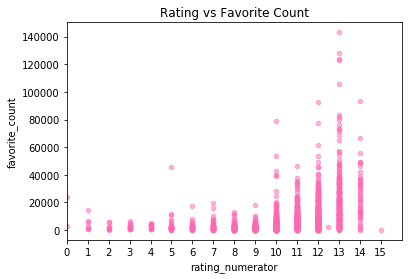

In [67]:
wrd_clean.plot(x='rating_numerator', y='favorite_count', kind='scatter', xlim=(0,16), xticks=np.arange(0,16,1),
               color = 'hotpink', alpha = 0.5, title = 'Rating vs Favorite Count');

In [64]:
#whats the correlation coefficient?
wrd_clean['rating_numerator'].corr(wrd_clean['favorite_count'])

0.014978735119229047

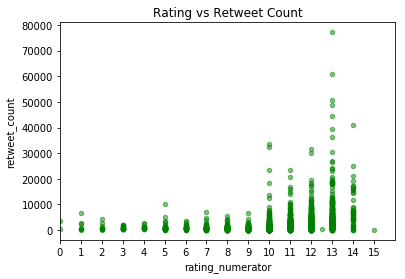

In [68]:
wrd_clean.plot(x='rating_numerator', y='retweet_count', kind='scatter',xlim=(0,16), xticks=np.arange(0,16,1),
               color = 'green', alpha = 0.5, title = 'Rating vs Retweet Count');

In [49]:
#whats the correlation coefficient?
wrd_clean['rating_numerator'].corr(wrd_clean['retweet_count'])

0.01579113290290526

For both of these comparisons, there doesn't seem to be much linear correlation (both have very low correlation coefficients), but there is definitely a trend. The lower rated dogs have a smaller, lower range for both favorite_count and retweet_count, while the higher rated dogs have a larger range, which means they are much more likely to have a high favorited_count or retweet_count. Both of these graphs are left-skewed.